# 비트코인 수익률 변동성 예측_GARCH(1,1) + EGARCH + LSTM

# 1a

X_train: (6534, 42, 5) Y_train: (6534, 1)
X_test: (554, 42, 5) Y_test: (554, 1)
Epoch 1/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 19s 1s/step - loss: 3.5606e-04 - root_mean_squared_error: 0.0184 - val_loss: 1.1258e-04 - val_root_mean_squared_error: 0.0106
Epoch 2/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 26s 2s/step - loss: 3.0045e-04 - root_mean_squared_error: 0.0168 - val_loss: 7.2040e-05 - val_root_mean_squared_error: 0.0085
Epoch 3/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 26s 2s/step - loss: 7.9385e-05 - root_mean_squared_error: 0.0089 - val_loss: 3.4273e-05 - val_root_mean_squared_error: 0.0059
Epoch 4/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 26s 2s/step - loss: 7.1044e-05 - root_mean_squared_error: 0.0084 - val_loss: 2.4977e-05 - val_root_mean_squared_error: 0.0050
Epoch 5/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 26s 2s/step - loss: 1.5612e-04 - root_mean_squared_error: 0.0120 - val_loss: 2.2569e-05 - val_root_mean_squared_error: 0.0048
Epoch 6/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 27s 2s/step - loss: 2.6775e-05 - root_mean_squared_error

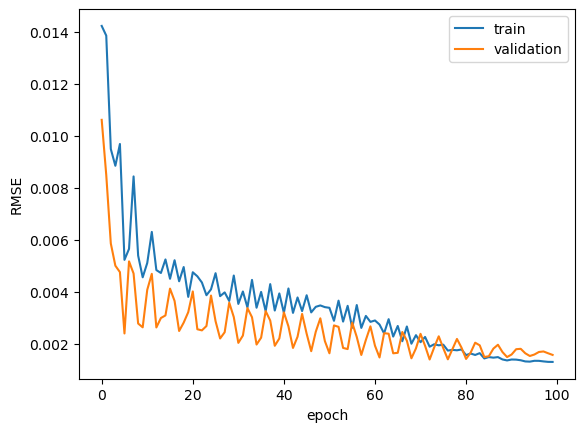

18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 74ms/step

RMSE: 0.00222

HMAE: 1.55698
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step


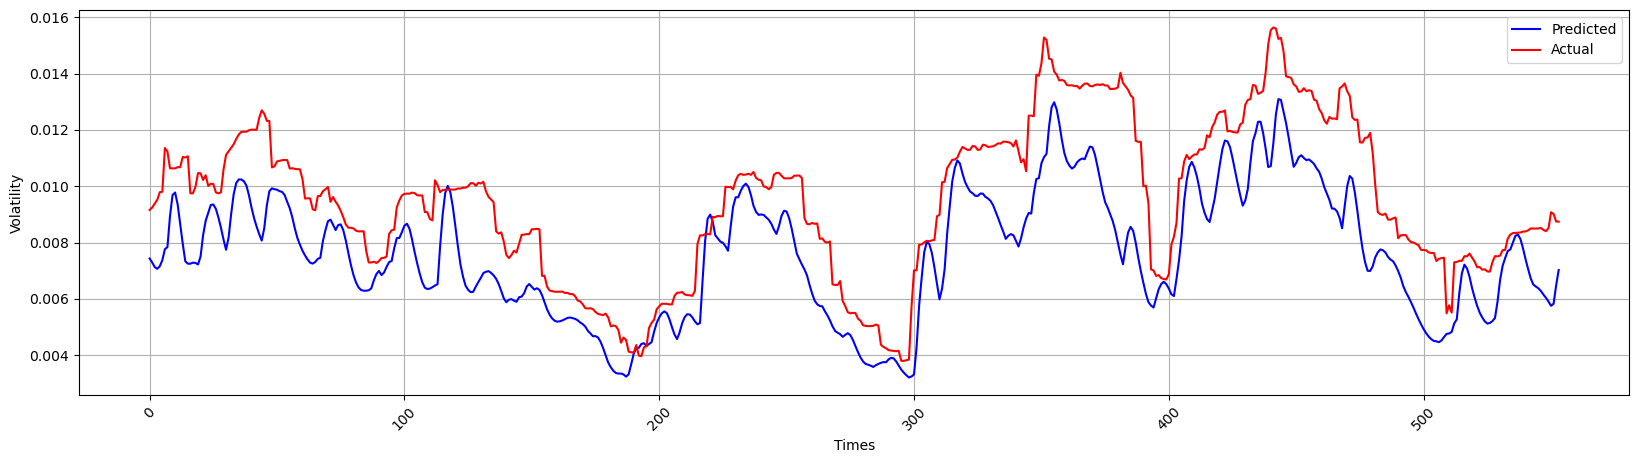

In [1]:
# 6/13 수정중
# HMAE 코드 수정
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.losses import Loss
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import math
import random

# 데이터셋 준비
df = pd.read_csv('finally_para_py_GARCH1_2_BTC_CBOE_VIX_KOSPI200_USDKRW.csv')

# 'index' 열의 datetime 변환 및 인덱스 설정
df['index'] = pd.to_datetime(df['datetime'])
df.set_index(df['index'], inplace=True)

# 경제지표 모두 추가
X_garch = df[['garch_vol', 'egarch_vol', 'KOSPI200_vol','CBOE_VIX_vol','USD_KRW_vol']].values 

# # 경제지표 다 뺌
# X_garch = df[['garch_vol', 'predicted_volatility']].values 

# #USD_KRW_vol만 추가
# X_garch = df[['garch_vol', 'predicted_volatility','USD_KRW_vol']].values 

# #'CBOE_VIX_vol'만 추가
# X_garch = df[['garch_vol', 'predicted_volatility','CBOE_VIX_vol']].values 

# #KOSPI200_vol만 추가
# X_garch = df[['garch_vol', 'predicted_volatility','KOSPI200_vol']].values

# #USD + CBOE 조합
# X_garch = df[['garch_vol', 'predicted_volatility','USD_KRW_vol','CBOE_VIX_vol']].values 

# #USD + KOSPI 조합
# X_garch = df[['garch_vol', 'predicted_volatility','USD_KRW_vol','KOSPI200_vol']].values 

# #CEOB + KOSPI 조합
# X_garch = df[['garch_vol', 'predicted_volatility','CBOE_VIX_vol','KOSPI200_vol']].values 

y = df['historical_volatility'].values

def dataset_split(x_set, y_set):
    train_end = df.index.get_loc('2022-12-31 21:00:00')
    valid_end = df.index.get_loc('2023-12-31 21:00:00')
    train_x = x_set[:train_end + 1]
    train_y = y_set[:train_end + 1]
    valid_x = x_set[train_end + 1:valid_end + 1]
    valid_y = y_set[train_end + 1:valid_end + 1]
    test_x = x_set[valid_end + 1:]
    test_y = y_set[valid_end + 1:]
    return train_x, train_y, valid_x, valid_y, test_x, test_y

train_X_garch, train_y_garch, valid_X_garch, valid_y_garch, test_X_garch, test_y_garch = dataset_split(X_garch, y)

# 스케일러 초기화
scaler_x = MinMaxScaler(feature_range=(0, 1))
train_X_scaled = scaler_x.fit_transform(train_X_garch)
valid_X_scaled = scaler_x.transform(valid_X_garch)
test_X_scaled = scaler_x.transform(test_X_garch)

sequence = 42
X_train, Y_train = [], []
for index in range(len(train_X_scaled) - sequence):
    X_train.append(np.array(train_X_scaled[index: index + sequence]))
    Y_train.append(np.ravel(train_y_garch[index + sequence:index + sequence + 1]))
X_train, Y_train = np.array(X_train), np.array(Y_train)

X_valid, Y_valid = [], []
for index in range(len(valid_X_scaled) - sequence):
    X_valid.append(np.array(valid_X_scaled[index: index + sequence]))
    Y_valid.append(np.ravel(valid_y_garch[index + sequence:index + sequence + 1]))
X_valid, Y_valid = np.array(X_valid), np.array(Y_valid)

X_test, Y_test = [], []
for index in range(len(test_X_scaled) - sequence):
    X_test.append(np.array(test_X_scaled[index: index + sequence]))
    Y_test.append(np.ravel(test_y_garch[index + sequence:index + sequence + 1]))
X_test, Y_test = np.array(X_test), np.array(Y_test)

train_y_garch = Y_train
valid_y_garch = Y_valid
test_y_garch = Y_test

train_X_garch = X_train.reshape(X_train.shape[0], sequence, -1)
valid_X_garch = X_valid.reshape(X_valid.shape[0], sequence, -1)
test_X_garch = X_test.reshape(X_test.shape[0], sequence, -1)

print('X_train:', train_X_garch.shape, 'Y_train:', train_y_garch.shape)
print('X_test:', test_X_garch.shape, 'Y_test:', test_y_garch.shape)


# HMAE 계산 함수
class HMAELoss(Loss):
    def __init__(self, name='hmae_loss'):
        super(HMAELoss, self).__init__(name=name)

    def call(self, y_true, y_pred):
        error = tf.abs(y_true - y_pred)
        variance = tf.math.reduce_variance(tf.cast(y_true - y_pred, tf.float32), axis=-1)
        hmae = tf.reduce_mean(error / tf.sqrt(variance + tf.keras.backend.epsilon()))
        return hmae

stop_early = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=40, verbose=1)

def build_model():
    inputLSTM_GARCH_EGARCH = tf.keras.layers.Input(shape=(train_X_garch.shape[1], train_X_garch.shape[2]))
    y = tf.keras.layers.LSTM(units=500, return_sequences=True)(inputLSTM_GARCH_EGARCH)
    y = tf.keras.layers.LSTM(units=500)(y)
    y = tf.keras.layers.Dense(1)(y)

    model = tf.keras.Model(inputs=inputLSTM_GARCH_EGARCH, outputs=y)

    model.compile(optimizer=tf.keras.optimizers.Adam(1e-4),
                  loss=tf.keras.losses.MeanSquaredError(),
                  metrics=[tf.keras.metrics.RootMeanSquaredError()])
    return model


SEED = 42
tf.random.set_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)

model = build_model()
history = model.fit(train_X_garch, train_y_garch,
                    epochs=100,
                    validation_data=(valid_X_garch, valid_y_garch),
                    batch_size=512,
                    callbacks=[stop_early],
                    shuffle=False)


def model_RMSE_plot(hist_model, model_name):
    plt.plot(hist_model.history['root_mean_squared_error'])
    plt.plot(hist_model.history['val_root_mean_squared_error'])
    #plt.title('{} train vs validation RMSE'.format(model_name))
    plt.ylabel('RMSE')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper right')
    plt.show()

def printing_out_results_of_a_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    y_test = y_test.flatten()
    y_pred = y_pred.flatten()

    rmse = math.sqrt(mean_squared_error(y_test, y_pred))
    print(f"\nRMSE: {rmse:.5f}")

    hmae_loss = HMAELoss()
    hmae_value = hmae_loss(tf.convert_to_tensor(y_test, dtype=tf.float32), tf.convert_to_tensor(y_pred, dtype=tf.float32))
    print(f"\nHMAE: {hmae_value.numpy():.5f}")

model_RMSE_plot(history, "LSTM_GARCH_EGARCH_vol")
printing_out_results_of_a_model(model, test_X_garch, test_y_garch)

def result_to_excel(model, test_X_garch, test_y_garch):
    result_df = pd.DataFrame(columns=['Prediction_y', 'Actual_y'])
    for ind, prediction in enumerate(model.predict(test_X_garch)):
        result_df.loc[ind] = [prediction[0], test_y_garch[ind]]
    result_df.to_excel('LSTM_GARCH_EGARCH_NEW_a.xlsx', index=False)
    return result_df

result_df = result_to_excel(model, test_X_garch, test_y_garch)
plt.figure(figsize=(20, 5))
plt.plot(result_df['Prediction_y'], linestyle='-', color='blue', label='Predicted')
plt.plot(result_df['Actual_y'], linestyle='-', color='red', label='Actual')
plt.xlabel('Times')
plt.ylabel('Volatility')
plt.xticks(rotation=45)
plt.grid(True)
plt.legend()
plt.show()

# 2b

X_train: (6534, 42, 2) Y_train: (6534, 1)
X_test: (554, 42, 2) Y_test: (554, 1)
Epoch 1/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 23s 1s/step - loss: 5.2793e-05 - root_mean_squared_error: 0.0072 - val_loss: 5.2373e-05 - val_root_mean_squared_error: 0.0072
Epoch 2/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 20s 2s/step - loss: 2.3044e-05 - root_mean_squared_error: 0.0048 - val_loss: 1.2923e-05 - val_root_mean_squared_error: 0.0036
Epoch 3/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 22s 2s/step - loss: 1.6705e-05 - root_mean_squared_error: 0.0040 - val_loss: 2.5832e-06 - val_root_mean_squared_error: 0.0016
Epoch 4/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 21s 2s/step - loss: 5.5797e-06 - root_mean_squared_error: 0.0024 - val_loss: 2.3190e-06 - val_root_mean_squared_error: 0.0015
Epoch 5/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 21s 2s/step - loss: 5.9652e-06 - root_mean_squared_error: 0.0024 - val_loss: 2.5718e-06 - val_root_mean_squared_error: 0.0016
Epoch 6/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 22s 2s/step - loss: 2.9248e-06 - root_mean_squared_error

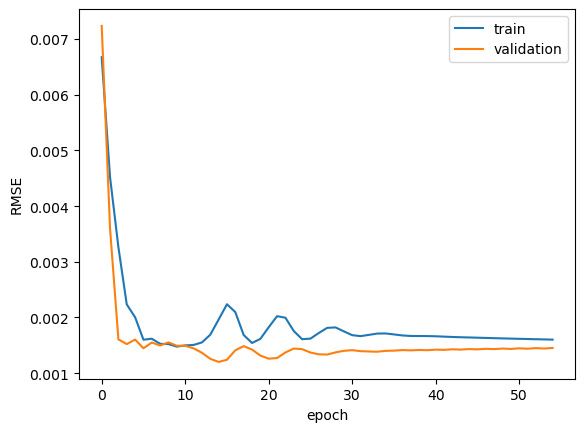

18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step

RMSE: 0.00182

HMAE: 1.29125
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step


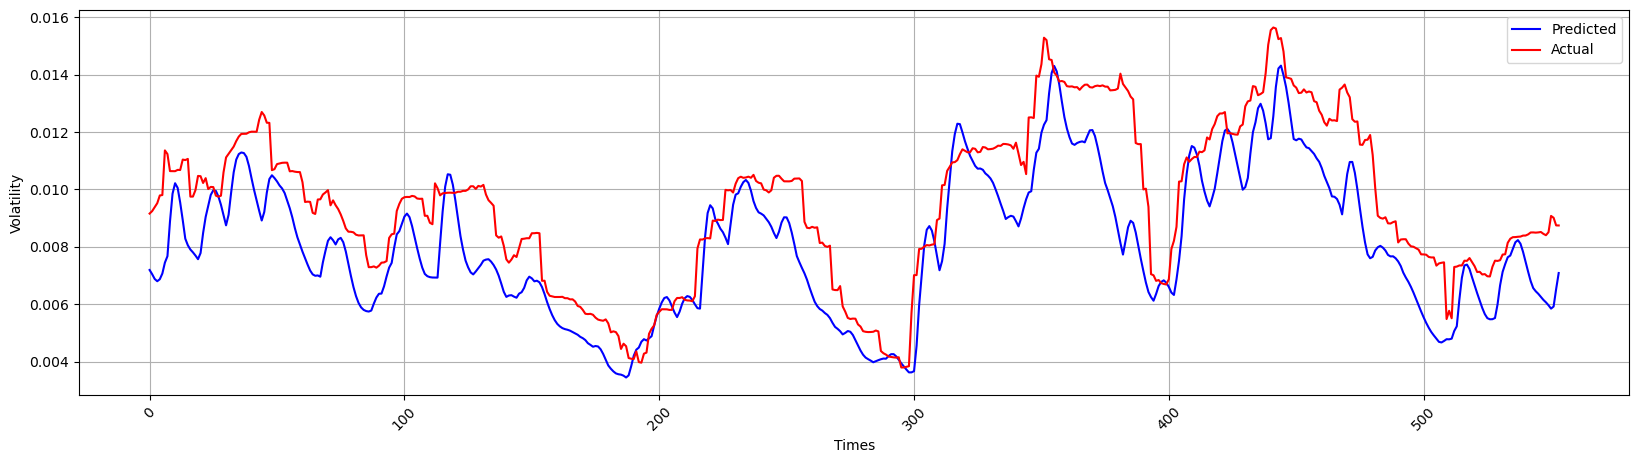

In [2]:
# 6/13 수정중
# HMAE 코드 수정
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.losses import Loss
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import math
import random

# 데이터셋 준비
df = pd.read_csv('finally_para_py_GARCH1_2_BTC_CBOE_VIX_KOSPI200_USDKRW.csv')

# 'index' 열의 datetime 변환 및 인덱스 설정
df['index'] = pd.to_datetime(df['datetime'])
df.set_index(df['index'], inplace=True)

# # 경제지표 모두 추가
# X_garch = df[['garch_vol', 'egarch_vol', 'predicted_volatility','KOSPI200_vol','CBOE_VIX_vol','USD_KRW_vol']].values 

# 경제지표 다 뺌
X_garch = df[['garch_vol', 'egarch_vol']].values 

# #USD_KRW_vol만 추가
# X_garch = df[['garch_vol', 'predicted_volatility','USD_KRW_vol']].values 

# #'CBOE_VIX_vol'만 추가
# X_garch = df[['garch_vol', 'predicted_volatility','CBOE_VIX_vol']].values 

# #KOSPI200_vol만 추가
# X_garch = df[['garch_vol', 'predicted_volatility','KOSPI200_vol']].values

# #USD + CBOE 조합
# X_garch = df[['garch_vol', 'predicted_volatility','USD_KRW_vol','CBOE_VIX_vol']].values 

# #USD + KOSPI 조합
# X_garch = df[['garch_vol', 'predicted_volatility','USD_KRW_vol','KOSPI200_vol']].values 

# #CEOB + KOSPI 조합
# X_garch = df[['garch_vol', 'predicted_volatility','CBOE_VIX_vol','KOSPI200_vol']].values 

y = df['historical_volatility'].values

def dataset_split(x_set, y_set):
    train_end = df.index.get_loc('2022-12-31 21:00:00')
    valid_end = df.index.get_loc('2023-12-31 21:00:00')
    train_x = x_set[:train_end + 1]
    train_y = y_set[:train_end + 1]
    valid_x = x_set[train_end + 1:valid_end + 1]
    valid_y = y_set[train_end + 1:valid_end + 1]
    test_x = x_set[valid_end + 1:]
    test_y = y_set[valid_end + 1:]
    return train_x, train_y, valid_x, valid_y, test_x, test_y

train_X_garch, train_y_garch, valid_X_garch, valid_y_garch, test_X_garch, test_y_garch = dataset_split(X_garch, y)

# 스케일러 초기화
scaler_x = MinMaxScaler(feature_range=(0, 1))
train_X_scaled = scaler_x.fit_transform(train_X_garch)
valid_X_scaled = scaler_x.transform(valid_X_garch)
test_X_scaled = scaler_x.transform(test_X_garch)

sequence = 42
X_train, Y_train = [], []
for index in range(len(train_X_scaled) - sequence):
    X_train.append(np.array(train_X_scaled[index: index + sequence]))
    Y_train.append(np.ravel(train_y_garch[index + sequence:index + sequence + 1]))
X_train, Y_train = np.array(X_train), np.array(Y_train)

X_valid, Y_valid = [], []
for index in range(len(valid_X_scaled) - sequence):
    X_valid.append(np.array(valid_X_scaled[index: index + sequence]))
    Y_valid.append(np.ravel(valid_y_garch[index + sequence:index + sequence + 1]))
X_valid, Y_valid = np.array(X_valid), np.array(Y_valid)

X_test, Y_test = [], []
for index in range(len(test_X_scaled) - sequence):
    X_test.append(np.array(test_X_scaled[index: index + sequence]))
    Y_test.append(np.ravel(test_y_garch[index + sequence:index + sequence + 1]))
X_test, Y_test = np.array(X_test), np.array(Y_test)

train_y_garch = Y_train
valid_y_garch = Y_valid
test_y_garch = Y_test

train_X_garch = X_train.reshape(X_train.shape[0], sequence, -1)
valid_X_garch = X_valid.reshape(X_valid.shape[0], sequence, -1)
test_X_garch = X_test.reshape(X_test.shape[0], sequence, -1)

print('X_train:', train_X_garch.shape, 'Y_train:', train_y_garch.shape)
print('X_test:', test_X_garch.shape, 'Y_test:', test_y_garch.shape)


# HMAE 계산 함수
class HMAELoss(Loss):
    def __init__(self, name='hmae_loss'):
        super(HMAELoss, self).__init__(name=name)

    def call(self, y_true, y_pred):
        error = tf.abs(y_true - y_pred)
        variance = tf.math.reduce_variance(tf.cast(y_true - y_pred, tf.float32), axis=-1)
        hmae = tf.reduce_mean(error / tf.sqrt(variance + tf.keras.backend.epsilon()))
        return hmae

stop_early = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=40, verbose=1)

def build_model():
    inputLSTM_GARCH_EGARCH = tf.keras.layers.Input(shape=(train_X_garch.shape[1], train_X_garch.shape[2]))
    y = tf.keras.layers.LSTM(units=500, return_sequences=True)(inputLSTM_GARCH_EGARCH)
    y = tf.keras.layers.LSTM(units=500)(y)
    y = tf.keras.layers.Dense(1)(y)

    model = tf.keras.Model(inputs=inputLSTM_GARCH_EGARCH, outputs=y)

    model.compile(optimizer=tf.keras.optimizers.Adam(1e-4),
                  loss=tf.keras.losses.MeanSquaredError(),
                  metrics=[tf.keras.metrics.RootMeanSquaredError()])
    return model


SEED = 42
tf.random.set_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)

model = build_model()
history = model.fit(train_X_garch, train_y_garch,
                    epochs=100,
                    validation_data=(valid_X_garch, valid_y_garch),
                    batch_size=512,
                    callbacks=[stop_early],
                    shuffle=False)


def model_RMSE_plot(hist_model, model_name):
    plt.plot(hist_model.history['root_mean_squared_error'])
    plt.plot(hist_model.history['val_root_mean_squared_error'])
    #plt.title('{} train vs validation RMSE'.format(model_name))
    plt.ylabel('RMSE')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper right')
    plt.show()

def printing_out_results_of_a_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    y_test = y_test.flatten()
    y_pred = y_pred.flatten()

    rmse = math.sqrt(mean_squared_error(y_test, y_pred))
    print(f"\nRMSE: {rmse:.5f}")

    hmae_loss = HMAELoss()
    hmae_value = hmae_loss(tf.convert_to_tensor(y_test, dtype=tf.float32), tf.convert_to_tensor(y_pred, dtype=tf.float32))
    print(f"\nHMAE: {hmae_value.numpy():.5f}")

model_RMSE_plot(history, "LSTM_GARCH_EGARCH_vol")
printing_out_results_of_a_model(model, test_X_garch, test_y_garch)

def result_to_excel(model, test_X_garch, test_y_garch):
    result_df = pd.DataFrame(columns=['Prediction_y', 'Actual_y'])
    for ind, prediction in enumerate(model.predict(test_X_garch)):
        result_df.loc[ind] = [prediction[0], test_y_garch[ind]]
    result_df.to_excel('LSTM_GARCH_EGARCH_NEW_b.xlsx', index=False)
    return result_df

result_df = result_to_excel(model, test_X_garch, test_y_garch)
plt.figure(figsize=(20, 5))
plt.plot(result_df['Prediction_y'], linestyle='-', color='blue', label='Predicted')
plt.plot(result_df['Actual_y'], linestyle='-', color='red', label='Actual')
plt.xlabel('Times')
plt.ylabel('Volatility')
plt.xticks(rotation=45)
plt.grid(True)
plt.legend()
plt.show()

# 3c

X_train: (6534, 42, 3) Y_train: (6534, 1)
X_test: (554, 42, 3) Y_test: (554, 1)
Epoch 1/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 21s 1s/step - loss: 1.2859e-05 - root_mean_squared_error: 0.0036 - val_loss: 6.4322e-06 - val_root_mean_squared_error: 0.0025
Epoch 2/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 18s 1s/step - loss: 1.5517e-05 - root_mean_squared_error: 0.0039 - val_loss: 2.2364e-05 - val_root_mean_squared_error: 0.0047
Epoch 3/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 18s 1s/step - loss: 3.3688e-05 - root_mean_squared_error: 0.0057 - val_loss: 7.3865e-06 - val_root_mean_squared_error: 0.0027
Epoch 4/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 18s 1s/step - loss: 1.8655e-05 - root_mean_squared_error: 0.0042 - val_loss: 5.2149e-06 - val_root_mean_squared_error: 0.0023
Epoch 5/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 18s 1s/step - loss: 1.6047e-05 - root_mean_squared_error: 0.0040 - val_loss: 2.5742e-05 - val_root_mean_squared_error: 0.0051
Epoch 6/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 18s 1s/step - loss: 5.1934e-05 - root_mean_squared_error

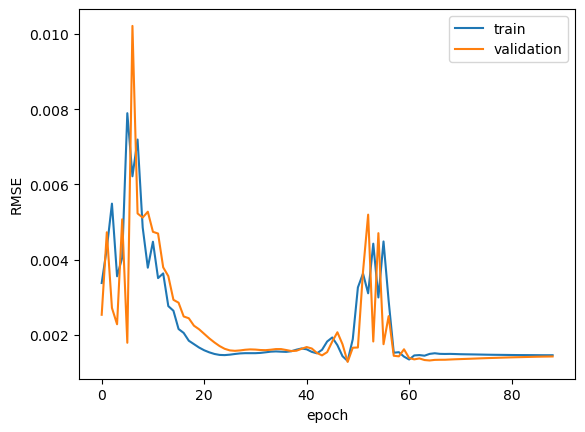

18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 79ms/step

RMSE: 0.00188

HMAE: 1.37897
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step


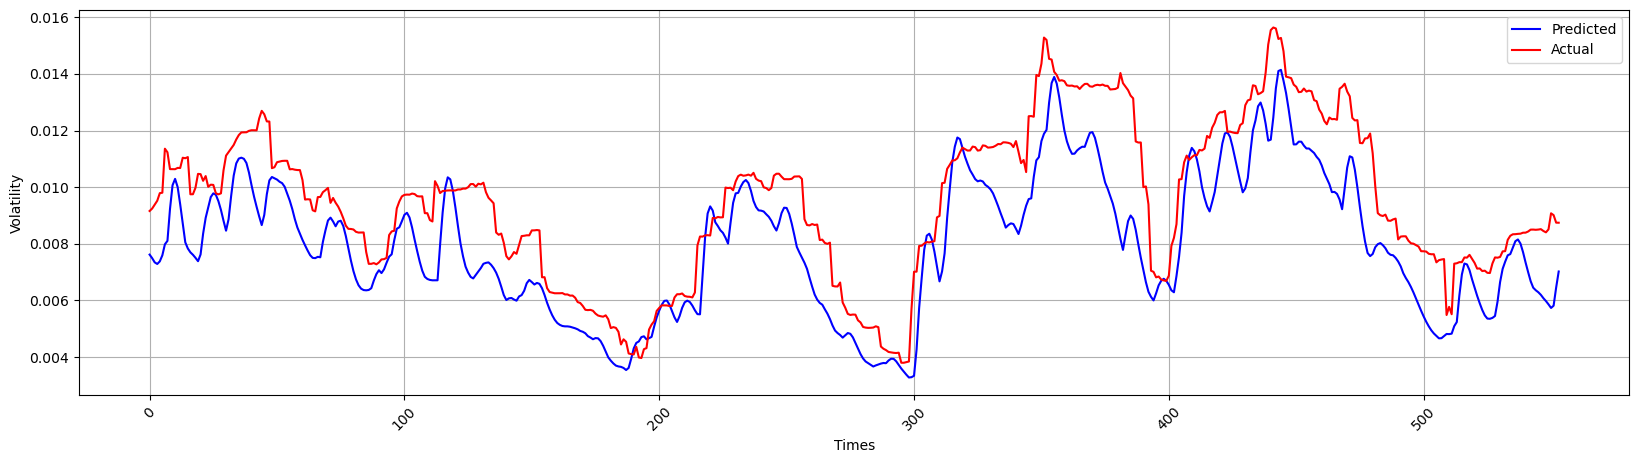

In [3]:
# 6/13 수정중
# HMAE 코드 수정
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.losses import Loss
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import math
import random

# 데이터셋 준비
df = pd.read_csv('finally_para_py_GARCH1_2_BTC_CBOE_VIX_KOSPI200_USDKRW.csv')

# 'index' 열의 datetime 변환 및 인덱스 설정
df['index'] = pd.to_datetime(df['datetime'])
df.set_index(df['index'], inplace=True)

# # 경제지표 모두 추가
# X_garch = df[['garch_vol', 'egarch_vol', 'predicted_volatility','KOSPI200_vol','CBOE_VIX_vol','USD_KRW_vol']].values 

# # 경제지표 다 뺌
# X_garch = df[['garch_vol', 'egarch_vol', 'predicted_volatility']].values 

#USD_KRW_vol만 추가
X_garch = df[['garch_vol', 'egarch_vol', 'USD_KRW_vol']].values 

# #'CBOE_VIX_vol'만 추가
# X_garch = df[['garch_vol', 'predicted_volatility','CBOE_VIX_vol']].values 

# #KOSPI200_vol만 추가
# X_garch = df[['garch_vol', 'predicted_volatility','KOSPI200_vol']].values

# #USD + CBOE 조합
# X_garch = df[['garch_vol', 'predicted_volatility','USD_KRW_vol','CBOE_VIX_vol']].values 

# #USD + KOSPI 조합
# X_garch = df[['garch_vol', 'predicted_volatility','USD_KRW_vol','KOSPI200_vol']].values 

# #CEOB + KOSPI 조합
# X_garch = df[['garch_vol', 'predicted_volatility','CBOE_VIX_vol','KOSPI200_vol']].values 

y = df['historical_volatility'].values

def dataset_split(x_set, y_set):
    train_end = df.index.get_loc('2022-12-31 21:00:00')
    valid_end = df.index.get_loc('2023-12-31 21:00:00')
    train_x = x_set[:train_end + 1]
    train_y = y_set[:train_end + 1]
    valid_x = x_set[train_end + 1:valid_end + 1]
    valid_y = y_set[train_end + 1:valid_end + 1]
    test_x = x_set[valid_end + 1:]
    test_y = y_set[valid_end + 1:]
    return train_x, train_y, valid_x, valid_y, test_x, test_y

train_X_garch, train_y_garch, valid_X_garch, valid_y_garch, test_X_garch, test_y_garch = dataset_split(X_garch, y)

# 스케일러 초기화
scaler_x = MinMaxScaler(feature_range=(0, 1))
train_X_scaled = scaler_x.fit_transform(train_X_garch)
valid_X_scaled = scaler_x.transform(valid_X_garch)
test_X_scaled = scaler_x.transform(test_X_garch)

sequence = 42
X_train, Y_train = [], []
for index in range(len(train_X_scaled) - sequence):
    X_train.append(np.array(train_X_scaled[index: index + sequence]))
    Y_train.append(np.ravel(train_y_garch[index + sequence:index + sequence + 1]))
X_train, Y_train = np.array(X_train), np.array(Y_train)

X_valid, Y_valid = [], []
for index in range(len(valid_X_scaled) - sequence):
    X_valid.append(np.array(valid_X_scaled[index: index + sequence]))
    Y_valid.append(np.ravel(valid_y_garch[index + sequence:index + sequence + 1]))
X_valid, Y_valid = np.array(X_valid), np.array(Y_valid)

X_test, Y_test = [], []
for index in range(len(test_X_scaled) - sequence):
    X_test.append(np.array(test_X_scaled[index: index + sequence]))
    Y_test.append(np.ravel(test_y_garch[index + sequence:index + sequence + 1]))
X_test, Y_test = np.array(X_test), np.array(Y_test)

train_y_garch = Y_train
valid_y_garch = Y_valid
test_y_garch = Y_test

train_X_garch = X_train.reshape(X_train.shape[0], sequence, -1)
valid_X_garch = X_valid.reshape(X_valid.shape[0], sequence, -1)
test_X_garch = X_test.reshape(X_test.shape[0], sequence, -1)

print('X_train:', train_X_garch.shape, 'Y_train:', train_y_garch.shape)
print('X_test:', test_X_garch.shape, 'Y_test:', test_y_garch.shape)


# HMAE 계산 함수
class HMAELoss(Loss):
    def __init__(self, name='hmae_loss'):
        super(HMAELoss, self).__init__(name=name)

    def call(self, y_true, y_pred):
        error = tf.abs(y_true - y_pred)
        variance = tf.math.reduce_variance(tf.cast(y_true - y_pred, tf.float32), axis=-1)
        hmae = tf.reduce_mean(error / tf.sqrt(variance + tf.keras.backend.epsilon()))
        return hmae

stop_early = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=40, verbose=1)

def build_model():
    inputLSTM_GARCH_EGARCH = tf.keras.layers.Input(shape=(train_X_garch.shape[1], train_X_garch.shape[2]))
    y = tf.keras.layers.LSTM(units=500, return_sequences=True)(inputLSTM_GARCH_EGARCH)
    y = tf.keras.layers.LSTM(units=500)(y)
    y = tf.keras.layers.Dense(1)(y)

    model = tf.keras.Model(inputs=inputLSTM_GARCH_EGARCH, outputs=y)

    model.compile(optimizer=tf.keras.optimizers.Adam(1e-4),
                  loss=tf.keras.losses.MeanSquaredError(),
                  metrics=[tf.keras.metrics.RootMeanSquaredError()])
    return model


SEED = 42
tf.random.set_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)

model = build_model()
history = model.fit(train_X_garch, train_y_garch,
                    epochs=100,
                    validation_data=(valid_X_garch, valid_y_garch),
                    batch_size=512,
                    callbacks=[stop_early],
                    shuffle=False)


def model_RMSE_plot(hist_model, model_name):
    plt.plot(hist_model.history['root_mean_squared_error'])
    plt.plot(hist_model.history['val_root_mean_squared_error'])
    #plt.title('{} train vs validation RMSE'.format(model_name))
    plt.ylabel('RMSE')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper right')
    plt.show()

def printing_out_results_of_a_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    y_test = y_test.flatten()
    y_pred = y_pred.flatten()

    rmse = math.sqrt(mean_squared_error(y_test, y_pred))
    print(f"\nRMSE: {rmse:.5f}")

    hmae_loss = HMAELoss()
    hmae_value = hmae_loss(tf.convert_to_tensor(y_test, dtype=tf.float32), tf.convert_to_tensor(y_pred, dtype=tf.float32))
    print(f"\nHMAE: {hmae_value.numpy():.5f}")

model_RMSE_plot(history, "LSTM_GARCH_EGARCH_vol")
printing_out_results_of_a_model(model, test_X_garch, test_y_garch)

def result_to_excel(model, test_X_garch, test_y_garch):
    result_df = pd.DataFrame(columns=['Prediction_y', 'Actual_y'])
    for ind, prediction in enumerate(model.predict(test_X_garch)):
        result_df.loc[ind] = [prediction[0], test_y_garch[ind]]
    result_df.to_excel('LSTM_GARCH_EGARCH_NEW_c.xlsx', index=False)
    return result_df

result_df = result_to_excel(model, test_X_garch, test_y_garch)
plt.figure(figsize=(20, 5))
plt.plot(result_df['Prediction_y'], linestyle='-', color='blue', label='Predicted')
plt.plot(result_df['Actual_y'], linestyle='-', color='red', label='Actual')
plt.xlabel('Times')
plt.ylabel('Volatility')
plt.xticks(rotation=45)
plt.grid(True)
plt.legend()
plt.show()

# 4d

X_train: (6534, 42, 3) Y_train: (6534, 1)
X_test: (554, 42, 3) Y_test: (554, 1)
Epoch 1/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 28s 2s/step - loss: 2.1568e-04 - root_mean_squared_error: 0.0143 - val_loss: 1.2130e-04 - val_root_mean_squared_error: 0.0110
Epoch 2/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 21s 2s/step - loss: 2.5239e-04 - root_mean_squared_error: 0.0150 - val_loss: 1.0122e-05 - val_root_mean_squared_error: 0.0032
Epoch 3/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 23s 2s/step - loss: 4.4253e-05 - root_mean_squared_error: 0.0066 - val_loss: 7.2536e-06 - val_root_mean_squared_error: 0.0027
Epoch 4/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 22s 2s/step - loss: 3.0286e-05 - root_mean_squared_error: 0.0054 - val_loss: 1.6167e-05 - val_root_mean_squared_error: 0.0040
Epoch 5/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 22s 2s/step - loss: 2.8568e-05 - root_mean_squared_error: 0.0051 - val_loss: 1.0946e-05 - val_root_mean_squared_error: 0.0033
Epoch 6/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 23s 2s/step - loss: 1.1028e-05 - root_mean_squared_error

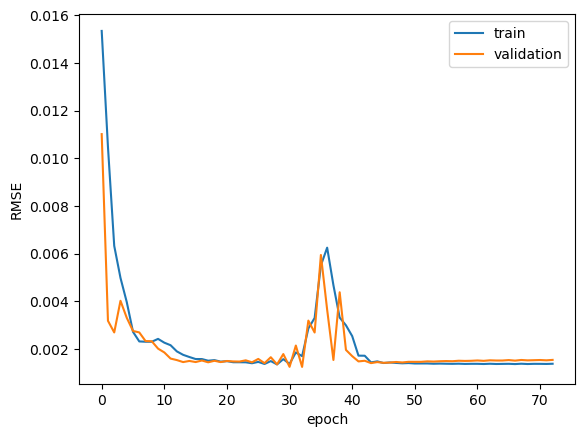

18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step

RMSE: 0.00193

HMAE: 1.40514
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step


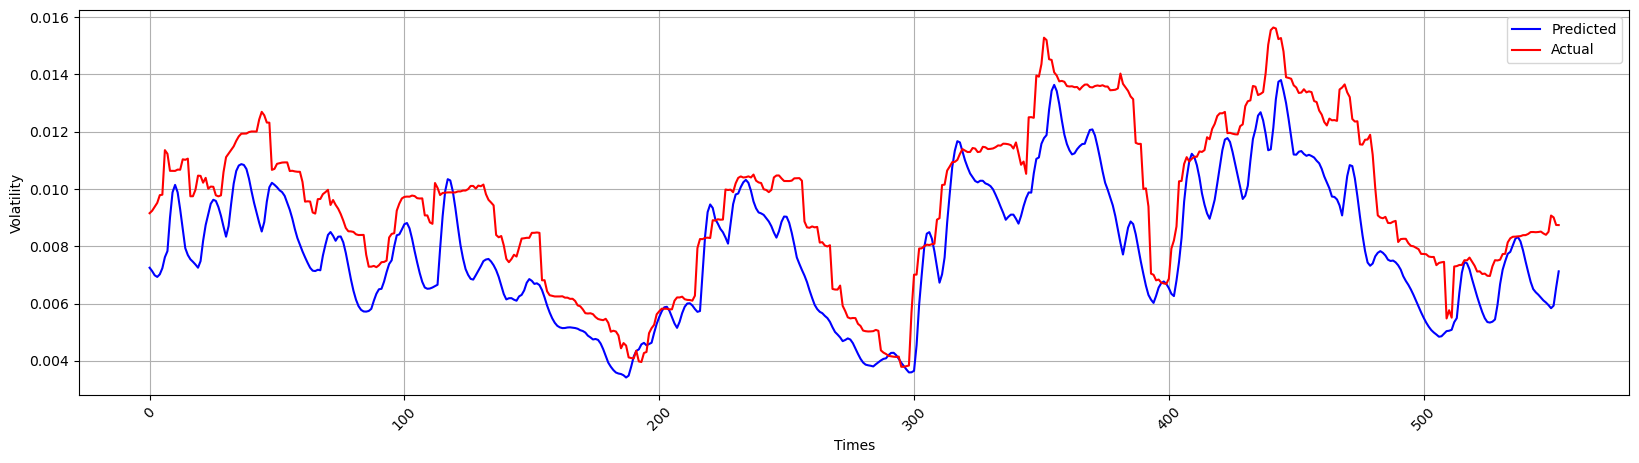

In [4]:
# 6/13 수정중
# HMAE 코드 수정
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.losses import Loss
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import math
import random

# 데이터셋 준비
df = pd.read_csv('finally_para_py_GARCH1_2_BTC_CBOE_VIX_KOSPI200_USDKRW.csv')

# 'index' 열의 datetime 변환 및 인덱스 설정
df['index'] = pd.to_datetime(df['datetime'])
df.set_index(df['index'], inplace=True)

# # 경제지표 모두 추가
# X_garch = df[['garch_vol', 'egarch_vol', 'predicted_volatility','KOSPI200_vol','CBOE_VIX_vol','USD_KRW_vol']].values 

# # 경제지표 다 뺌
# X_garch = df[['garch_vol', 'egarch_vol', 'predicted_volatility']].values 

# #USD_KRW_vol만 추가
# X_garch = df[['garch_vol', 'egarch_vol', 'predicted_volatility','USD_KRW_vol']].values 

#'CBOE_VIX_vol'만 추가
X_garch = df[['garch_vol', 'egarch_vol', 'CBOE_VIX_vol']].values 

# #KOSPI200_vol만 추가
# X_garch = df[['garch_vol', 'predicted_volatility','KOSPI200_vol']].values

# #USD + CBOE 조합
# X_garch = df[['garch_vol', 'predicted_volatility','USD_KRW_vol','CBOE_VIX_vol']].values 

# #USD + KOSPI 조합
# X_garch = df[['garch_vol', 'predicted_volatility','USD_KRW_vol','KOSPI200_vol']].values 

# #CEOB + KOSPI 조합
# X_garch = df[['garch_vol', 'predicted_volatility','CBOE_VIX_vol','KOSPI200_vol']].values 

y = df['historical_volatility'].values

def dataset_split(x_set, y_set):
    train_end = df.index.get_loc('2022-12-31 21:00:00')
    valid_end = df.index.get_loc('2023-12-31 21:00:00')
    train_x = x_set[:train_end + 1]
    train_y = y_set[:train_end + 1]
    valid_x = x_set[train_end + 1:valid_end + 1]
    valid_y = y_set[train_end + 1:valid_end + 1]
    test_x = x_set[valid_end + 1:]
    test_y = y_set[valid_end + 1:]
    return train_x, train_y, valid_x, valid_y, test_x, test_y

train_X_garch, train_y_garch, valid_X_garch, valid_y_garch, test_X_garch, test_y_garch = dataset_split(X_garch, y)

# 스케일러 초기화
scaler_x = MinMaxScaler(feature_range=(0, 1))
train_X_scaled = scaler_x.fit_transform(train_X_garch)
valid_X_scaled = scaler_x.transform(valid_X_garch)
test_X_scaled = scaler_x.transform(test_X_garch)

sequence = 42
X_train, Y_train = [], []
for index in range(len(train_X_scaled) - sequence):
    X_train.append(np.array(train_X_scaled[index: index + sequence]))
    Y_train.append(np.ravel(train_y_garch[index + sequence:index + sequence + 1]))
X_train, Y_train = np.array(X_train), np.array(Y_train)

X_valid, Y_valid = [], []
for index in range(len(valid_X_scaled) - sequence):
    X_valid.append(np.array(valid_X_scaled[index: index + sequence]))
    Y_valid.append(np.ravel(valid_y_garch[index + sequence:index + sequence + 1]))
X_valid, Y_valid = np.array(X_valid), np.array(Y_valid)

X_test, Y_test = [], []
for index in range(len(test_X_scaled) - sequence):
    X_test.append(np.array(test_X_scaled[index: index + sequence]))
    Y_test.append(np.ravel(test_y_garch[index + sequence:index + sequence + 1]))
X_test, Y_test = np.array(X_test), np.array(Y_test)

train_y_garch = Y_train
valid_y_garch = Y_valid
test_y_garch = Y_test

train_X_garch = X_train.reshape(X_train.shape[0], sequence, -1)
valid_X_garch = X_valid.reshape(X_valid.shape[0], sequence, -1)
test_X_garch = X_test.reshape(X_test.shape[0], sequence, -1)

print('X_train:', train_X_garch.shape, 'Y_train:', train_y_garch.shape)
print('X_test:', test_X_garch.shape, 'Y_test:', test_y_garch.shape)


# HMAE 계산 함수
class HMAELoss(Loss):
    def __init__(self, name='hmae_loss'):
        super(HMAELoss, self).__init__(name=name)

    def call(self, y_true, y_pred):
        error = tf.abs(y_true - y_pred)
        variance = tf.math.reduce_variance(tf.cast(y_true - y_pred, tf.float32), axis=-1)
        hmae = tf.reduce_mean(error / tf.sqrt(variance + tf.keras.backend.epsilon()))
        return hmae

stop_early = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=40, verbose=1)

def build_model():
    inputLSTM_GARCH_EGARCH = tf.keras.layers.Input(shape=(train_X_garch.shape[1], train_X_garch.shape[2]))
    y = tf.keras.layers.LSTM(units=500, return_sequences=True)(inputLSTM_GARCH_EGARCH)
    y = tf.keras.layers.LSTM(units=500)(y)
    y = tf.keras.layers.Dense(1)(y)

    model = tf.keras.Model(inputs=inputLSTM_GARCH_EGARCH, outputs=y)

    model.compile(optimizer=tf.keras.optimizers.Adam(1e-4),
                  loss=tf.keras.losses.MeanSquaredError(),
                  metrics=[tf.keras.metrics.RootMeanSquaredError()])
    return model


SEED = 42
tf.random.set_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)

model = build_model()
history = model.fit(train_X_garch, train_y_garch,
                    epochs=100,
                    validation_data=(valid_X_garch, valid_y_garch),
                    batch_size=512,
                    callbacks=[stop_early],
                    shuffle=False)


def model_RMSE_plot(hist_model, model_name):
    plt.plot(hist_model.history['root_mean_squared_error'])
    plt.plot(hist_model.history['val_root_mean_squared_error'])
    #plt.title('{} train vs validation RMSE'.format(model_name))
    plt.ylabel('RMSE')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper right')
    plt.show()

def printing_out_results_of_a_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    y_test = y_test.flatten()
    y_pred = y_pred.flatten()

    rmse = math.sqrt(mean_squared_error(y_test, y_pred))
    print(f"\nRMSE: {rmse:.5f}")

    hmae_loss = HMAELoss()
    hmae_value = hmae_loss(tf.convert_to_tensor(y_test, dtype=tf.float32), tf.convert_to_tensor(y_pred, dtype=tf.float32))
    print(f"\nHMAE: {hmae_value.numpy():.5f}")

model_RMSE_plot(history, "LSTM_GARCH_EGARCH_vol")
printing_out_results_of_a_model(model, test_X_garch, test_y_garch)

def result_to_excel(model, test_X_garch, test_y_garch):
    result_df = pd.DataFrame(columns=['Prediction_y', 'Actual_y'])
    for ind, prediction in enumerate(model.predict(test_X_garch)):
        result_df.loc[ind] = [prediction[0], test_y_garch[ind]]
    result_df.to_excel('LSTM_GARCH_EGARCH_NEW_d.xlsx', index=False)
    return result_df

result_df = result_to_excel(model, test_X_garch, test_y_garch)
plt.figure(figsize=(20, 5))
plt.plot(result_df['Prediction_y'], linestyle='-', color='blue', label='Predicted')
plt.plot(result_df['Actual_y'], linestyle='-', color='red', label='Actual')
plt.xlabel('Times')
plt.ylabel('Volatility')
plt.xticks(rotation=45)
plt.grid(True)
plt.legend()
plt.show()

# 5e

X_train: (6534, 42, 3) Y_train: (6534, 1)
X_test: (554, 42, 3) Y_test: (554, 1)
Epoch 1/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 21s 1s/step - loss: 5.1427e-05 - root_mean_squared_error: 0.0071 - val_loss: 2.6658e-05 - val_root_mean_squared_error: 0.0052
Epoch 2/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 18s 1s/step - loss: 8.8875e-05 - root_mean_squared_error: 0.0094 - val_loss: 5.9041e-05 - val_root_mean_squared_error: 0.0077
Epoch 3/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 18s 1s/step - loss: 7.9571e-05 - root_mean_squared_error: 0.0086 - val_loss: 1.9375e-05 - val_root_mean_squared_error: 0.0044
Epoch 4/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 19s 1s/step - loss: 1.0303e-04 - root_mean_squared_error: 0.0101 - val_loss: 1.4794e-05 - val_root_mean_squared_error: 0.0038
Epoch 5/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 18s 1s/step - loss: 2.3430e-05 - root_mean_squared_error: 0.0048 - val_loss: 4.2110e-06 - val_root_mean_squared_error: 0.0021
Epoch 6/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 18s 1s/step - loss: 9.7519e-06 - root_mean_squared_error

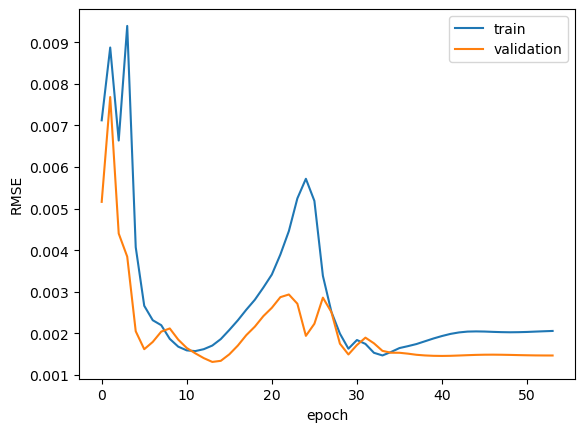

18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 110ms/step

RMSE: 0.00189

HMAE: 1.16386
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step


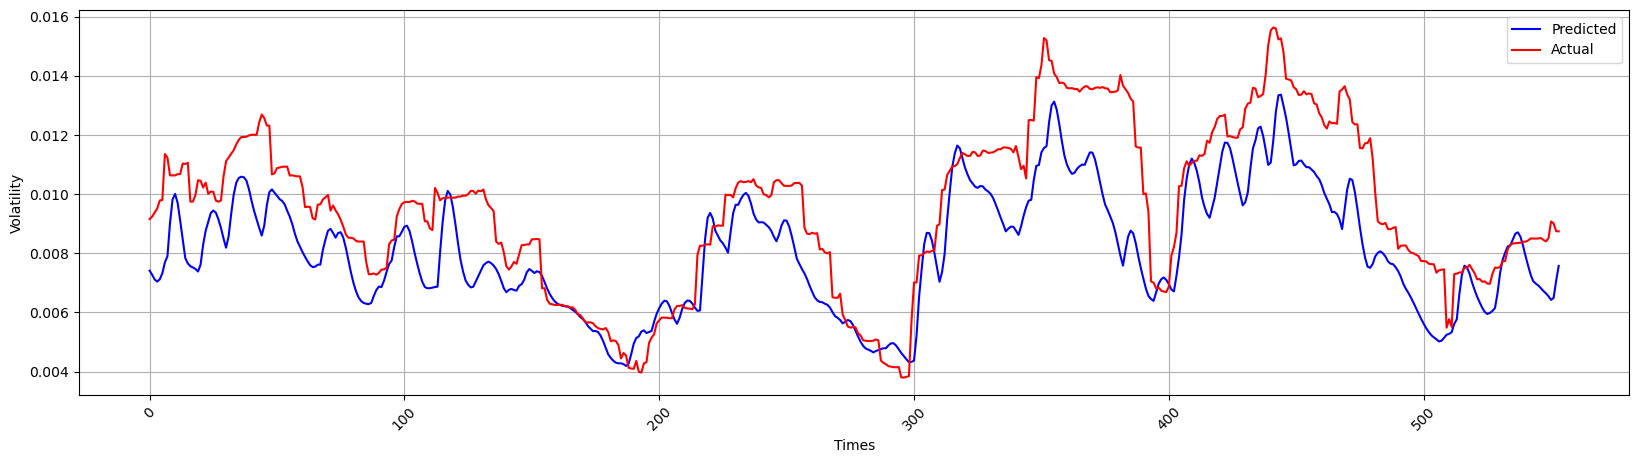

In [1]:
# 6/13 수정중
# HMAE 코드 수정
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.losses import Loss
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import math
import random

# 데이터셋 준비
df = pd.read_csv('finally_para_py_GARCH1_2_BTC_CBOE_VIX_KOSPI200_USDKRW.csv')

# 'index' 열의 datetime 변환 및 인덱스 설정
df['index'] = pd.to_datetime(df['datetime'])
df.set_index(df['index'], inplace=True)

# # 경제지표 모두 추가
# X_garch = df[['garch_vol', 'egarch_vol', 'predicted_volatility','KOSPI200_vol','CBOE_VIX_vol','USD_KRW_vol']].values 

# # 경제지표 다 뺌
# X_garch = df[['garch_vol', 'egarch_vol', 'predicted_volatility']].values 

# #USD_KRW_vol만 추가
# X_garch = df[['garch_vol', 'egarch_vol', 'predicted_volatility','USD_KRW_vol']].values 

# #'CBOE_VIX_vol'만 추가
# X_garch = df[['garch_vol', 'egarch_vol', 'predicted_volatility','CBOE_VIX_vol']].values 

#KOSPI200_vol만 추가
X_garch = df[['garch_vol', 'egarch_vol', 'KOSPI200_vol']].values

# #USD + CBOE 조합
# X_garch = df[['garch_vol', 'predicted_volatility','USD_KRW_vol','CBOE_VIX_vol']].values 

# #USD + KOSPI 조합
# X_garch = df[['garch_vol', 'predicted_volatility','USD_KRW_vol','KOSPI200_vol']].values 

# #CEOB + KOSPI 조합
# X_garch = df[['garch_vol', 'predicted_volatility','CBOE_VIX_vol','KOSPI200_vol']].values 

y = df['historical_volatility'].values

def dataset_split(x_set, y_set):
    train_end = df.index.get_loc('2022-12-31 21:00:00')
    valid_end = df.index.get_loc('2023-12-31 21:00:00')
    train_x = x_set[:train_end + 1]
    train_y = y_set[:train_end + 1]
    valid_x = x_set[train_end + 1:valid_end + 1]
    valid_y = y_set[train_end + 1:valid_end + 1]
    test_x = x_set[valid_end + 1:]
    test_y = y_set[valid_end + 1:]
    return train_x, train_y, valid_x, valid_y, test_x, test_y

train_X_garch, train_y_garch, valid_X_garch, valid_y_garch, test_X_garch, test_y_garch = dataset_split(X_garch, y)

# 스케일러 초기화
scaler_x = MinMaxScaler(feature_range=(0, 1))
train_X_scaled = scaler_x.fit_transform(train_X_garch)
valid_X_scaled = scaler_x.transform(valid_X_garch)
test_X_scaled = scaler_x.transform(test_X_garch)

sequence = 42
X_train, Y_train = [], []
for index in range(len(train_X_scaled) - sequence):
    X_train.append(np.array(train_X_scaled[index: index + sequence]))
    Y_train.append(np.ravel(train_y_garch[index + sequence:index + sequence + 1]))
X_train, Y_train = np.array(X_train), np.array(Y_train)

X_valid, Y_valid = [], []
for index in range(len(valid_X_scaled) - sequence):
    X_valid.append(np.array(valid_X_scaled[index: index + sequence]))
    Y_valid.append(np.ravel(valid_y_garch[index + sequence:index + sequence + 1]))
X_valid, Y_valid = np.array(X_valid), np.array(Y_valid)

X_test, Y_test = [], []
for index in range(len(test_X_scaled) - sequence):
    X_test.append(np.array(test_X_scaled[index: index + sequence]))
    Y_test.append(np.ravel(test_y_garch[index + sequence:index + sequence + 1]))
X_test, Y_test = np.array(X_test), np.array(Y_test)

train_y_garch = Y_train
valid_y_garch = Y_valid
test_y_garch = Y_test

train_X_garch = X_train.reshape(X_train.shape[0], sequence, -1)
valid_X_garch = X_valid.reshape(X_valid.shape[0], sequence, -1)
test_X_garch = X_test.reshape(X_test.shape[0], sequence, -1)

print('X_train:', train_X_garch.shape, 'Y_train:', train_y_garch.shape)
print('X_test:', test_X_garch.shape, 'Y_test:', test_y_garch.shape)


# HMAE 계산 함수
class HMAELoss(Loss):
    def __init__(self, name='hmae_loss'):
        super(HMAELoss, self).__init__(name=name)

    def call(self, y_true, y_pred):
        error = tf.abs(y_true - y_pred)
        variance = tf.math.reduce_variance(tf.cast(y_true - y_pred, tf.float32), axis=-1)
        hmae = tf.reduce_mean(error / tf.sqrt(variance + tf.keras.backend.epsilon()))
        return hmae

stop_early = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=40, verbose=1)

def build_model():
    inputLSTM_GARCH_EGARCH = tf.keras.layers.Input(shape=(train_X_garch.shape[1], train_X_garch.shape[2]))
    y = tf.keras.layers.LSTM(units=500, return_sequences=True)(inputLSTM_GARCH_EGARCH)
    y = tf.keras.layers.LSTM(units=500)(y)
    y = tf.keras.layers.Dense(1)(y)

    model = tf.keras.Model(inputs=inputLSTM_GARCH_EGARCH, outputs=y)

    model.compile(optimizer=tf.keras.optimizers.Adam(1e-4),
                  loss=tf.keras.losses.MeanSquaredError(),
                  metrics=[tf.keras.metrics.RootMeanSquaredError()])
    return model


SEED = 42
tf.random.set_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)

model = build_model()
history = model.fit(train_X_garch, train_y_garch,
                    epochs=100,
                    validation_data=(valid_X_garch, valid_y_garch),
                    batch_size=512,
                    callbacks=[stop_early],
                    shuffle=False)


def model_RMSE_plot(hist_model, model_name):
    plt.plot(hist_model.history['root_mean_squared_error'])
    plt.plot(hist_model.history['val_root_mean_squared_error'])
    #plt.title('{} train vs validation RMSE'.format(model_name))
    plt.ylabel('RMSE')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper right')
    plt.show()

def printing_out_results_of_a_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    y_test = y_test.flatten()
    y_pred = y_pred.flatten()

    rmse = math.sqrt(mean_squared_error(y_test, y_pred))
    print(f"\nRMSE: {rmse:.5f}")

    hmae_loss = HMAELoss()
    hmae_value = hmae_loss(tf.convert_to_tensor(y_test, dtype=tf.float32), tf.convert_to_tensor(y_pred, dtype=tf.float32))
    print(f"\nHMAE: {hmae_value.numpy():.5f}")

model_RMSE_plot(history, "LSTM_GARCH_EGARCH_vol")
printing_out_results_of_a_model(model, test_X_garch, test_y_garch)

def result_to_excel(model, test_X_garch, test_y_garch):
    result_df = pd.DataFrame(columns=['Prediction_y', 'Actual_y'])
    for ind, prediction in enumerate(model.predict(test_X_garch)):
        result_df.loc[ind] = [prediction[0], test_y_garch[ind]]
    result_df.to_excel('LSTM_GARCH_EGARCH_NEW_e.xlsx', index=False)
    return result_df

result_df = result_to_excel(model, test_X_garch, test_y_garch)
plt.figure(figsize=(20, 5))
plt.plot(result_df['Prediction_y'], linestyle='-', color='blue', label='Predicted')
plt.plot(result_df['Actual_y'], linestyle='-', color='red', label='Actual')
plt.xlabel('Times')
plt.ylabel('Volatility')
plt.xticks(rotation=45)
plt.grid(True)
plt.legend()
plt.show()

# 6f

X_train: (6534, 42, 4) Y_train: (6534, 1)
X_test: (554, 42, 4) Y_test: (554, 1)
Epoch 1/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 21s 1s/step - loss: 3.5720e-04 - root_mean_squared_error: 0.0186 - val_loss: 1.0316e-04 - val_root_mean_squared_error: 0.0102
Epoch 2/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 18s 1s/step - loss: 2.5160e-04 - root_mean_squared_error: 0.0152 - val_loss: 7.6107e-05 - val_root_mean_squared_error: 0.0087
Epoch 3/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 18s 1s/step - loss: 2.0783e-04 - root_mean_squared_error: 0.0142 - val_loss: 2.9134e-05 - val_root_mean_squared_error: 0.0054
Epoch 4/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 18s 1s/step - loss: 3.2078e-05 - root_mean_squared_error: 0.0057 - val_loss: 7.2478e-06 - val_root_mean_squared_error: 0.0027
Epoch 5/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 18s 1s/step - loss: 2.8951e-05 - root_mean_squared_error: 0.0052 - val_loss: 4.1784e-06 - val_root_mean_squared_error: 0.0020
Epoch 6/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 18s 1s/step - loss: 8.2482e-06 - root_mean_squared_error

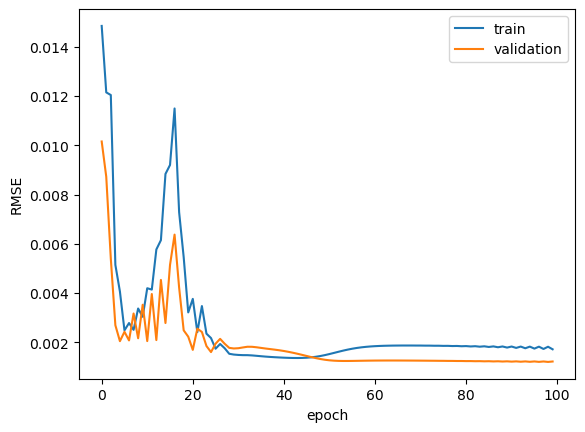

18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 74ms/step

RMSE: 0.00127

HMAE: 0.81396
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step


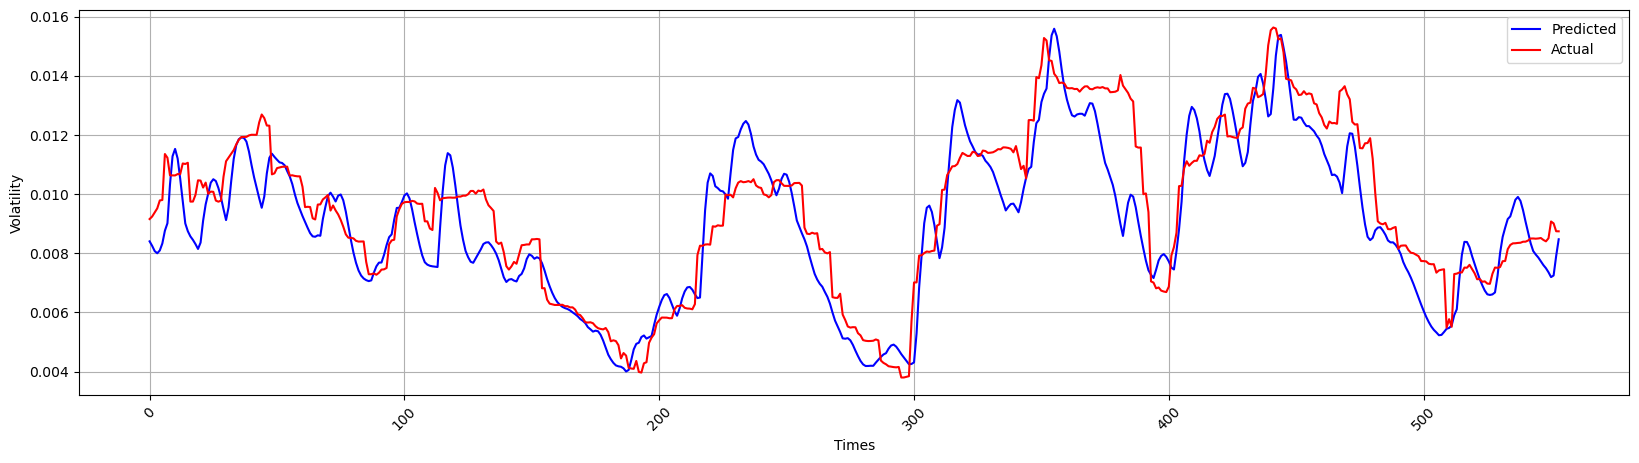

In [2]:
# 6/13 수정중
# HMAE 코드 수정
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.losses import Loss
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import math
import random

# 데이터셋 준비
df = pd.read_csv('finally_para_py_GARCH1_2_BTC_CBOE_VIX_KOSPI200_USDKRW.csv')

# 'index' 열의 datetime 변환 및 인덱스 설정
df['index'] = pd.to_datetime(df['datetime'])
df.set_index(df['index'], inplace=True)

# # 경제지표 모두 추가
# X_garch = df[['garch_vol', 'egarch_vol', 'predicted_volatility','KOSPI200_vol','CBOE_VIX_vol','USD_KRW_vol']].values 

# # 경제지표 다 뺌
# X_garch = df[['garch_vol', 'egarch_vol', 'predicted_volatility']].values 

# #USD_KRW_vol만 추가
# X_garch = df[['garch_vol', 'egarch_vol', 'predicted_volatility','USD_KRW_vol']].values 

# #'CBOE_VIX_vol'만 추가
# X_garch = df[['garch_vol', 'egarch_vol', 'predicted_volatility','CBOE_VIX_vol']].values 

# #KOSPI200_vol만 추가
# X_garch = df[['garch_vol', 'egarch_vol', 'predicted_volatility', 'KOSPI200_vol']].values

#USD + CBOE 조합
X_garch = df[['garch_vol', 'egarch_vol', 'USD_KRW_vol', 'CBOE_VIX_vol']].values 

# #USD + KOSPI 조합
# X_garch = df[['garch_vol', 'predicted_volatility','USD_KRW_vol','KOSPI200_vol']].values 

# #CEOB + KOSPI 조합
# X_garch = df[['garch_vol', 'predicted_volatility','CBOE_VIX_vol','KOSPI200_vol']].values 

y = df['historical_volatility'].values

def dataset_split(x_set, y_set):
    train_end = df.index.get_loc('2022-12-31 21:00:00')
    valid_end = df.index.get_loc('2023-12-31 21:00:00')
    train_x = x_set[:train_end + 1]
    train_y = y_set[:train_end + 1]
    valid_x = x_set[train_end + 1:valid_end + 1]
    valid_y = y_set[train_end + 1:valid_end + 1]
    test_x = x_set[valid_end + 1:]
    test_y = y_set[valid_end + 1:]
    return train_x, train_y, valid_x, valid_y, test_x, test_y

train_X_garch, train_y_garch, valid_X_garch, valid_y_garch, test_X_garch, test_y_garch = dataset_split(X_garch, y)

# 스케일러 초기화
scaler_x = MinMaxScaler(feature_range=(0, 1))
train_X_scaled = scaler_x.fit_transform(train_X_garch)
valid_X_scaled = scaler_x.transform(valid_X_garch)
test_X_scaled = scaler_x.transform(test_X_garch)

sequence = 42
X_train, Y_train = [], []
for index in range(len(train_X_scaled) - sequence):
    X_train.append(np.array(train_X_scaled[index: index + sequence]))
    Y_train.append(np.ravel(train_y_garch[index + sequence:index + sequence + 1]))
X_train, Y_train = np.array(X_train), np.array(Y_train)

X_valid, Y_valid = [], []
for index in range(len(valid_X_scaled) - sequence):
    X_valid.append(np.array(valid_X_scaled[index: index + sequence]))
    Y_valid.append(np.ravel(valid_y_garch[index + sequence:index + sequence + 1]))
X_valid, Y_valid = np.array(X_valid), np.array(Y_valid)

X_test, Y_test = [], []
for index in range(len(test_X_scaled) - sequence):
    X_test.append(np.array(test_X_scaled[index: index + sequence]))
    Y_test.append(np.ravel(test_y_garch[index + sequence:index + sequence + 1]))
X_test, Y_test = np.array(X_test), np.array(Y_test)

train_y_garch = Y_train
valid_y_garch = Y_valid
test_y_garch = Y_test

train_X_garch = X_train.reshape(X_train.shape[0], sequence, -1)
valid_X_garch = X_valid.reshape(X_valid.shape[0], sequence, -1)
test_X_garch = X_test.reshape(X_test.shape[0], sequence, -1)

print('X_train:', train_X_garch.shape, 'Y_train:', train_y_garch.shape)
print('X_test:', test_X_garch.shape, 'Y_test:', test_y_garch.shape)


# HMAE 계산 함수
class HMAELoss(Loss):
    def __init__(self, name='hmae_loss'):
        super(HMAELoss, self).__init__(name=name)

    def call(self, y_true, y_pred):
        error = tf.abs(y_true - y_pred)
        variance = tf.math.reduce_variance(tf.cast(y_true - y_pred, tf.float32), axis=-1)
        hmae = tf.reduce_mean(error / tf.sqrt(variance + tf.keras.backend.epsilon()))
        return hmae

stop_early = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=40, verbose=1)

def build_model():
    inputLSTM_GARCH_EGARCH = tf.keras.layers.Input(shape=(train_X_garch.shape[1], train_X_garch.shape[2]))
    y = tf.keras.layers.LSTM(units=500, return_sequences=True)(inputLSTM_GARCH_EGARCH)
    y = tf.keras.layers.LSTM(units=500)(y)
    y = tf.keras.layers.Dense(1)(y)

    model = tf.keras.Model(inputs=inputLSTM_GARCH_EGARCH, outputs=y)

    model.compile(optimizer=tf.keras.optimizers.Adam(1e-4),
                  loss=tf.keras.losses.MeanSquaredError(),
                  metrics=[tf.keras.metrics.RootMeanSquaredError()])
    return model


SEED = 42
tf.random.set_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)

model = build_model()
history = model.fit(train_X_garch, train_y_garch,
                    epochs=100,
                    validation_data=(valid_X_garch, valid_y_garch),
                    batch_size=512,
                    callbacks=[stop_early],
                    shuffle=False)


def model_RMSE_plot(hist_model, model_name):
    plt.plot(hist_model.history['root_mean_squared_error'])
    plt.plot(hist_model.history['val_root_mean_squared_error'])
    #plt.title('{} train vs validation RMSE'.format(model_name))
    plt.ylabel('RMSE')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper right')
    plt.show()

def printing_out_results_of_a_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    y_test = y_test.flatten()
    y_pred = y_pred.flatten()

    rmse = math.sqrt(mean_squared_error(y_test, y_pred))
    print(f"\nRMSE: {rmse:.5f}")

    hmae_loss = HMAELoss()
    hmae_value = hmae_loss(tf.convert_to_tensor(y_test, dtype=tf.float32), tf.convert_to_tensor(y_pred, dtype=tf.float32))
    print(f"\nHMAE: {hmae_value.numpy():.5f}")

model_RMSE_plot(history, "LSTM_GARCH_EGARCH_vol")
printing_out_results_of_a_model(model, test_X_garch, test_y_garch)

def result_to_excel(model, test_X_garch, test_y_garch):
    result_df = pd.DataFrame(columns=['Prediction_y', 'Actual_y'])
    for ind, prediction in enumerate(model.predict(test_X_garch)):
        result_df.loc[ind] = [prediction[0], test_y_garch[ind]]
    result_df.to_excel('LSTM_GARCH_EGARCH_NEW_f.xlsx', index=False)
    return result_df

result_df = result_to_excel(model, test_X_garch, test_y_garch)
plt.figure(figsize=(20, 5))
plt.plot(result_df['Prediction_y'], linestyle='-', color='blue', label='Predicted')
plt.plot(result_df['Actual_y'], linestyle='-', color='red', label='Actual')
plt.xlabel('Times')
plt.ylabel('Volatility')
plt.xticks(rotation=45)
plt.grid(True)
plt.legend()
plt.show()

# 7g

X_train: (6534, 42, 4) Y_train: (6534, 1)
X_test: (554, 42, 4) Y_test: (554, 1)
Epoch 1/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 22s 1s/step - loss: 2.5915e-04 - root_mean_squared_error: 0.0157 - val_loss: 2.5088e-05 - val_root_mean_squared_error: 0.0050
Epoch 2/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 18s 1s/step - loss: 1.0451e-04 - root_mean_squared_error: 0.0100 - val_loss: 6.0023e-05 - val_root_mean_squared_error: 0.0077
Epoch 3/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 18s 1s/step - loss: 3.8678e-05 - root_mean_squared_error: 0.0062 - val_loss: 6.3970e-05 - val_root_mean_squared_error: 0.0080
Epoch 4/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 18s 1s/step - loss: 5.0184e-05 - root_mean_squared_error: 0.0071 - val_loss: 3.1128e-05 - val_root_mean_squared_error: 0.0056
Epoch 5/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 18s 1s/step - loss: 4.4603e-05 - root_mean_squared_error: 0.0067 - val_loss: 1.1521e-05 - val_root_mean_squared_error: 0.0034
Epoch 6/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 18s 1s/step - loss: 1.3524e-05 - root_mean_squared_error

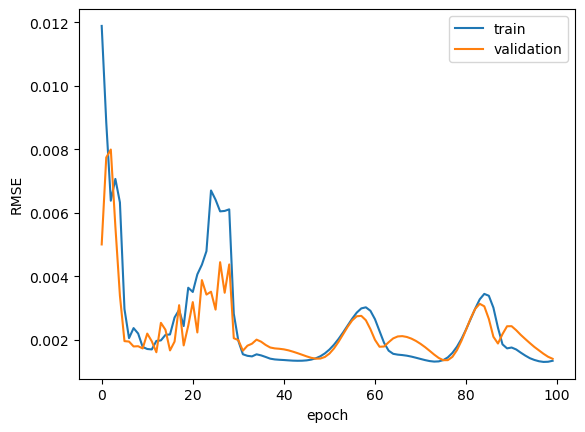

18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step

RMSE: 0.00192

HMAE: 1.34699
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step


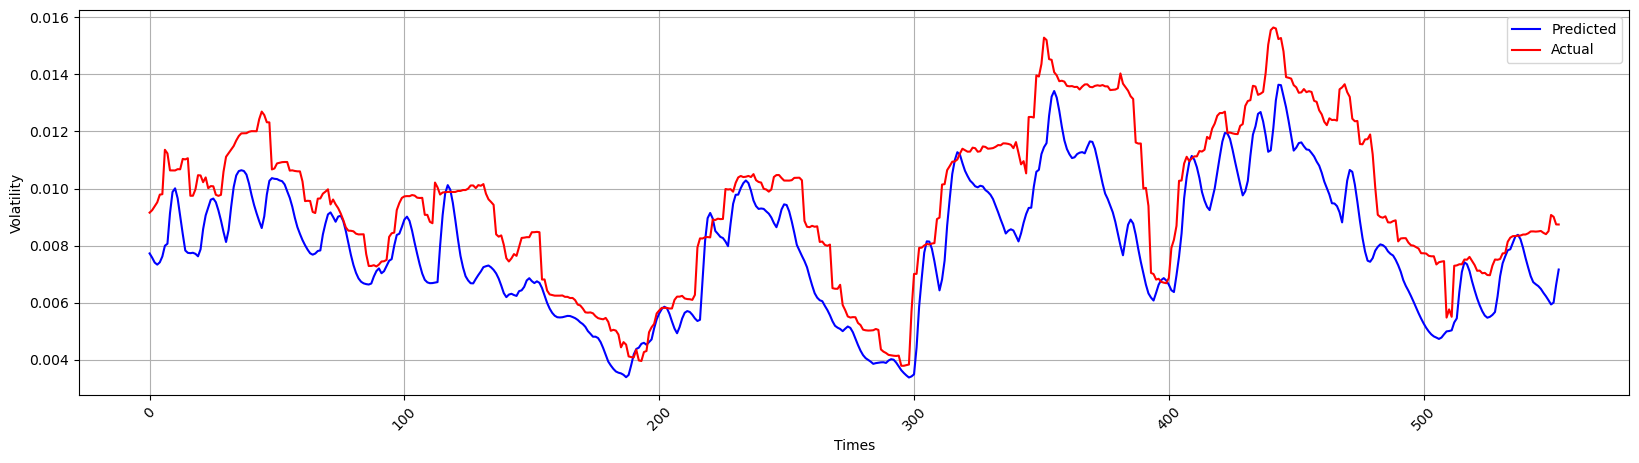

In [3]:
# 6/13 수정중
# HMAE 코드 수정
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.losses import Loss
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import math
import random

# 데이터셋 준비
df = pd.read_csv('finally_para_py_GARCH1_2_BTC_CBOE_VIX_KOSPI200_USDKRW.csv')

# 'index' 열의 datetime 변환 및 인덱스 설정
df['index'] = pd.to_datetime(df['datetime'])
df.set_index(df['index'], inplace=True)

# # 경제지표 모두 추가
# X_garch = df[['garch_vol', 'egarch_vol', 'predicted_volatility','KOSPI200_vol','CBOE_VIX_vol','USD_KRW_vol']].values 

# # 경제지표 다 뺌
# X_garch = df[['garch_vol', 'egarch_vol', 'predicted_volatility']].values 

# #USD_KRW_vol만 추가
# X_garch = df[['garch_vol', 'egarch_vol', 'predicted_volatility','USD_KRW_vol']].values 

# #'CBOE_VIX_vol'만 추가
# X_garch = df[['garch_vol', 'egarch_vol', 'predicted_volatility','CBOE_VIX_vol']].values 

# #KOSPI200_vol만 추가
# X_garch = df[['garch_vol', 'egarch_vol', 'predicted_volatility', 'KOSPI200_vol']].values

# #USD + CBOE 조합
# X_garch = df[['garch_vol', 'egarch_vol', 'predicted_volatility','USD_KRW_vol','CBOE_VIX_vol']].values 

#USD + KOSPI 조합
X_garch = df[['garch_vol', 'egarch_vol', 'USD_KRW_vol', 'KOSPI200_vol']].values 

# #CEOB + KOSPI 조합
# X_garch = df[['garch_vol', 'predicted_volatility','CBOE_VIX_vol','KOSPI200_vol']].values 

y = df['historical_volatility'].values

def dataset_split(x_set, y_set):
    train_end = df.index.get_loc('2022-12-31 21:00:00')
    valid_end = df.index.get_loc('2023-12-31 21:00:00')
    train_x = x_set[:train_end + 1]
    train_y = y_set[:train_end + 1]
    valid_x = x_set[train_end + 1:valid_end + 1]
    valid_y = y_set[train_end + 1:valid_end + 1]
    test_x = x_set[valid_end + 1:]
    test_y = y_set[valid_end + 1:]
    return train_x, train_y, valid_x, valid_y, test_x, test_y

train_X_garch, train_y_garch, valid_X_garch, valid_y_garch, test_X_garch, test_y_garch = dataset_split(X_garch, y)

# 스케일러 초기화
scaler_x = MinMaxScaler(feature_range=(0, 1))
train_X_scaled = scaler_x.fit_transform(train_X_garch)
valid_X_scaled = scaler_x.transform(valid_X_garch)
test_X_scaled = scaler_x.transform(test_X_garch)

sequence = 42
X_train, Y_train = [], []
for index in range(len(train_X_scaled) - sequence):
    X_train.append(np.array(train_X_scaled[index: index + sequence]))
    Y_train.append(np.ravel(train_y_garch[index + sequence:index + sequence + 1]))
X_train, Y_train = np.array(X_train), np.array(Y_train)

X_valid, Y_valid = [], []
for index in range(len(valid_X_scaled) - sequence):
    X_valid.append(np.array(valid_X_scaled[index: index + sequence]))
    Y_valid.append(np.ravel(valid_y_garch[index + sequence:index + sequence + 1]))
X_valid, Y_valid = np.array(X_valid), np.array(Y_valid)

X_test, Y_test = [], []
for index in range(len(test_X_scaled) - sequence):
    X_test.append(np.array(test_X_scaled[index: index + sequence]))
    Y_test.append(np.ravel(test_y_garch[index + sequence:index + sequence + 1]))
X_test, Y_test = np.array(X_test), np.array(Y_test)

train_y_garch = Y_train
valid_y_garch = Y_valid
test_y_garch = Y_test

train_X_garch = X_train.reshape(X_train.shape[0], sequence, -1)
valid_X_garch = X_valid.reshape(X_valid.shape[0], sequence, -1)
test_X_garch = X_test.reshape(X_test.shape[0], sequence, -1)

print('X_train:', train_X_garch.shape, 'Y_train:', train_y_garch.shape)
print('X_test:', test_X_garch.shape, 'Y_test:', test_y_garch.shape)


# HMAE 계산 함수
class HMAELoss(Loss):
    def __init__(self, name='hmae_loss'):
        super(HMAELoss, self).__init__(name=name)

    def call(self, y_true, y_pred):
        error = tf.abs(y_true - y_pred)
        variance = tf.math.reduce_variance(tf.cast(y_true - y_pred, tf.float32), axis=-1)
        hmae = tf.reduce_mean(error / tf.sqrt(variance + tf.keras.backend.epsilon()))
        return hmae

stop_early = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=40, verbose=1)

def build_model():
    inputLSTM_GARCH_EGARCH = tf.keras.layers.Input(shape=(train_X_garch.shape[1], train_X_garch.shape[2]))
    y = tf.keras.layers.LSTM(units=500, return_sequences=True)(inputLSTM_GARCH_EGARCH)
    y = tf.keras.layers.LSTM(units=500)(y)
    y = tf.keras.layers.Dense(1)(y)

    model = tf.keras.Model(inputs=inputLSTM_GARCH_EGARCH, outputs=y)

    model.compile(optimizer=tf.keras.optimizers.Adam(1e-4),
                  loss=tf.keras.losses.MeanSquaredError(),
                  metrics=[tf.keras.metrics.RootMeanSquaredError()])
    return model


SEED = 42
tf.random.set_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)

model = build_model()
history = model.fit(train_X_garch, train_y_garch,
                    epochs=100,
                    validation_data=(valid_X_garch, valid_y_garch),
                    batch_size=512,
                    callbacks=[stop_early],
                    shuffle=False)


def model_RMSE_plot(hist_model, model_name):
    plt.plot(hist_model.history['root_mean_squared_error'])
    plt.plot(hist_model.history['val_root_mean_squared_error'])
    #plt.title('{} train vs validation RMSE'.format(model_name))
    plt.ylabel('RMSE')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper right')
    plt.show()

def printing_out_results_of_a_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    y_test = y_test.flatten()
    y_pred = y_pred.flatten()

    rmse = math.sqrt(mean_squared_error(y_test, y_pred))
    print(f"\nRMSE: {rmse:.5f}")

    hmae_loss = HMAELoss()
    hmae_value = hmae_loss(tf.convert_to_tensor(y_test, dtype=tf.float32), tf.convert_to_tensor(y_pred, dtype=tf.float32))
    print(f"\nHMAE: {hmae_value.numpy():.5f}")

model_RMSE_plot(history, "LSTM_GARCH_EGARCH_vol")
printing_out_results_of_a_model(model, test_X_garch, test_y_garch)

def result_to_excel(model, test_X_garch, test_y_garch):
    result_df = pd.DataFrame(columns=['Prediction_y', 'Actual_y'])
    for ind, prediction in enumerate(model.predict(test_X_garch)):
        result_df.loc[ind] = [prediction[0], test_y_garch[ind]]
    result_df.to_excel('LSTM_GARCH_EGARCH_NEW_g.xlsx', index=False)
    return result_df

result_df = result_to_excel(model, test_X_garch, test_y_garch)
plt.figure(figsize=(20, 5))
plt.plot(result_df['Prediction_y'], linestyle='-', color='blue', label='Predicted')
plt.plot(result_df['Actual_y'], linestyle='-', color='red', label='Actual')
plt.xlabel('Times')
plt.ylabel('Volatility')
plt.xticks(rotation=45)
plt.grid(True)
plt.legend()
plt.show()

# 8h

X_train: (6534, 42, 4) Y_train: (6534, 1)
X_test: (554, 42, 4) Y_test: (554, 1)
Epoch 1/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 23s 1s/step - loss: 2.7014e-04 - root_mean_squared_error: 0.0161 - val_loss: 5.0046e-05 - val_root_mean_squared_error: 0.0071
Epoch 2/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 18s 1s/step - loss: 1.5996e-04 - root_mean_squared_error: 0.0121 - val_loss: 4.3343e-05 - val_root_mean_squared_error: 0.0066
Epoch 3/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 18s 1s/step - loss: 8.1261e-05 - root_mean_squared_error: 0.0087 - val_loss: 3.8272e-05 - val_root_mean_squared_error: 0.0062
Epoch 4/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 18s 1s/step - loss: 2.9000e-05 - root_mean_squared_error: 0.0053 - val_loss: 1.6365e-05 - val_root_mean_squared_error: 0.0040
Epoch 5/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 18s 1s/step - loss: 1.8944e-05 - root_mean_squared_error: 0.0043 - val_loss: 1.1519e-05 - val_root_mean_squared_error: 0.0034
Epoch 6/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 18s 1s/step - loss: 8.5121e-06 - root_mean_squared_error

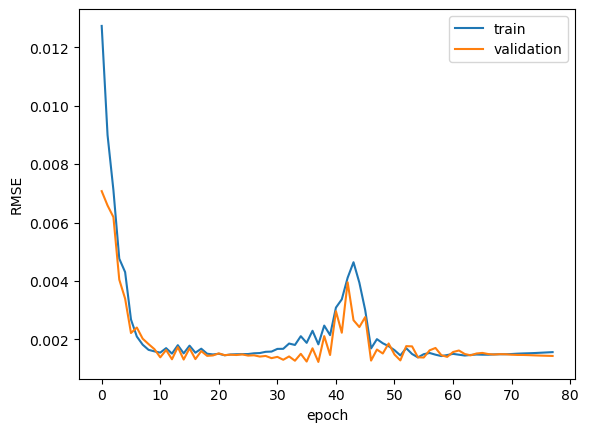

18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 84ms/step

RMSE: 0.00173

HMAE: 1.21152
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step


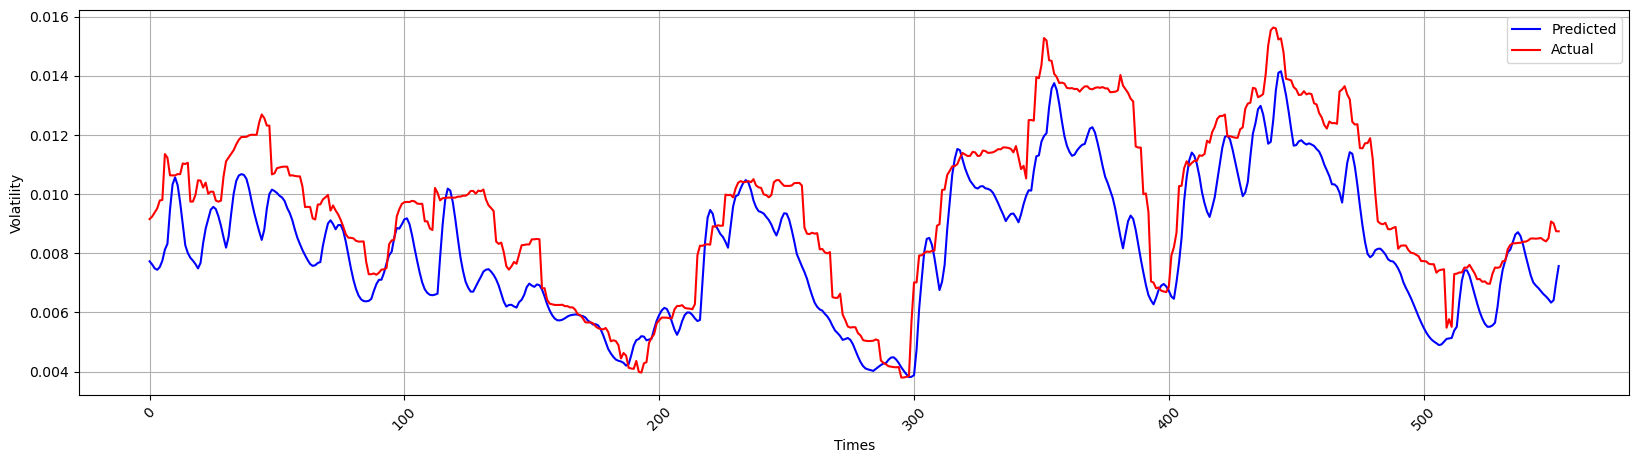

In [4]:
# 6/13 수정중
# HMAE 코드 수정
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.losses import Loss
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import math
import random

# 데이터셋 준비
df = pd.read_csv('finally_para_py_GARCH1_2_BTC_CBOE_VIX_KOSPI200_USDKRW.csv')

# 'index' 열의 datetime 변환 및 인덱스 설정
df['index'] = pd.to_datetime(df['datetime'])
df.set_index(df['index'], inplace=True)

# # 경제지표 모두 추가
# X_garch = df[['garch_vol', 'egarch_vol', 'predicted_volatility','KOSPI200_vol','CBOE_VIX_vol','USD_KRW_vol']].values 

# # 경제지표 다 뺌
# X_garch = df[['garch_vol', 'egarch_vol', 'predicted_volatility']].values 

# #USD_KRW_vol만 추가
# X_garch = df[['garch_vol', 'egarch_vol', 'predicted_volatility','USD_KRW_vol']].values 

# #'CBOE_VIX_vol'만 추가
# X_garch = df[['garch_vol', 'egarch_vol', 'predicted_volatility','CBOE_VIX_vol']].values 

# #KOSPI200_vol만 추가
# X_garch = df[['garch_vol', 'egarch_vol', 'predicted_volatility', 'KOSPI200_vol']].values

# #USD + CBOE 조합
# X_garch = df[['garch_vol', 'egarch_vol', 'predicted_volatility','USD_KRW_vol','CBOE_VIX_vol']].values 

# #USD + KOSPI 조합
# X_garch = df[['garch_vol', 'egarch_vol', 'predicted_volatility','USD_KRW_vol','KOSPI200_vol']].values 

#CEOB + KOSPI 조합
X_garch = df[['garch_vol', 'egarch_vol', 'CBOE_VIX_vol','KOSPI200_vol']].values 

y = df['historical_volatility'].values

def dataset_split(x_set, y_set):
    train_end = df.index.get_loc('2022-12-31 21:00:00')
    valid_end = df.index.get_loc('2023-12-31 21:00:00')
    train_x = x_set[:train_end + 1]
    train_y = y_set[:train_end + 1]
    valid_x = x_set[train_end + 1:valid_end + 1]
    valid_y = y_set[train_end + 1:valid_end + 1]
    test_x = x_set[valid_end + 1:]
    test_y = y_set[valid_end + 1:]
    return train_x, train_y, valid_x, valid_y, test_x, test_y

train_X_garch, train_y_garch, valid_X_garch, valid_y_garch, test_X_garch, test_y_garch = dataset_split(X_garch, y)

# 스케일러 초기화
scaler_x = MinMaxScaler(feature_range=(0, 1))
train_X_scaled = scaler_x.fit_transform(train_X_garch)
valid_X_scaled = scaler_x.transform(valid_X_garch)
test_X_scaled = scaler_x.transform(test_X_garch)

sequence = 42
X_train, Y_train = [], []
for index in range(len(train_X_scaled) - sequence):
    X_train.append(np.array(train_X_scaled[index: index + sequence]))
    Y_train.append(np.ravel(train_y_garch[index + sequence:index + sequence + 1]))
X_train, Y_train = np.array(X_train), np.array(Y_train)

X_valid, Y_valid = [], []
for index in range(len(valid_X_scaled) - sequence):
    X_valid.append(np.array(valid_X_scaled[index: index + sequence]))
    Y_valid.append(np.ravel(valid_y_garch[index + sequence:index + sequence + 1]))
X_valid, Y_valid = np.array(X_valid), np.array(Y_valid)

X_test, Y_test = [], []
for index in range(len(test_X_scaled) - sequence):
    X_test.append(np.array(test_X_scaled[index: index + sequence]))
    Y_test.append(np.ravel(test_y_garch[index + sequence:index + sequence + 1]))
X_test, Y_test = np.array(X_test), np.array(Y_test)

train_y_garch = Y_train
valid_y_garch = Y_valid
test_y_garch = Y_test

train_X_garch = X_train.reshape(X_train.shape[0], sequence, -1)
valid_X_garch = X_valid.reshape(X_valid.shape[0], sequence, -1)
test_X_garch = X_test.reshape(X_test.shape[0], sequence, -1)

print('X_train:', train_X_garch.shape, 'Y_train:', train_y_garch.shape)
print('X_test:', test_X_garch.shape, 'Y_test:', test_y_garch.shape)


# HMAE 계산 함수
class HMAELoss(Loss):
    def __init__(self, name='hmae_loss'):
        super(HMAELoss, self).__init__(name=name)

    def call(self, y_true, y_pred):
        error = tf.abs(y_true - y_pred)
        variance = tf.math.reduce_variance(tf.cast(y_true - y_pred, tf.float32), axis=-1)
        hmae = tf.reduce_mean(error / tf.sqrt(variance + tf.keras.backend.epsilon()))
        return hmae

stop_early = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=40, verbose=1)

def build_model():
    inputLSTM_GARCH_EGARCH = tf.keras.layers.Input(shape=(train_X_garch.shape[1], train_X_garch.shape[2]))
    y = tf.keras.layers.LSTM(units=500, return_sequences=True)(inputLSTM_GARCH_EGARCH)
    y = tf.keras.layers.LSTM(units=500)(y)
    y = tf.keras.layers.Dense(1)(y)

    model = tf.keras.Model(inputs=inputLSTM_GARCH_EGARCH, outputs=y)

    model.compile(optimizer=tf.keras.optimizers.Adam(1e-4),
                  loss=tf.keras.losses.MeanSquaredError(),
                  metrics=[tf.keras.metrics.RootMeanSquaredError()])
    return model


SEED = 42
tf.random.set_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)

model = build_model()
history = model.fit(train_X_garch, train_y_garch,
                    epochs=100,
                    validation_data=(valid_X_garch, valid_y_garch),
                    batch_size=512,
                    callbacks=[stop_early],
                    shuffle=False)


def model_RMSE_plot(hist_model, model_name):
    plt.plot(hist_model.history['root_mean_squared_error'])
    plt.plot(hist_model.history['val_root_mean_squared_error'])
    #plt.title('{} train vs validation RMSE'.format(model_name))
    plt.ylabel('RMSE')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper right')
    plt.show()

def printing_out_results_of_a_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    y_test = y_test.flatten()
    y_pred = y_pred.flatten()

    rmse = math.sqrt(mean_squared_error(y_test, y_pred))
    print(f"\nRMSE: {rmse:.5f}")

    hmae_loss = HMAELoss()
    hmae_value = hmae_loss(tf.convert_to_tensor(y_test, dtype=tf.float32), tf.convert_to_tensor(y_pred, dtype=tf.float32))
    print(f"\nHMAE: {hmae_value.numpy():.5f}")

model_RMSE_plot(history, "LSTM_GARCH_EGARCH_vol")
printing_out_results_of_a_model(model, test_X_garch, test_y_garch)

def result_to_excel(model, test_X_garch, test_y_garch):
    result_df = pd.DataFrame(columns=['Prediction_y', 'Actual_y'])
    for ind, prediction in enumerate(model.predict(test_X_garch)):
        result_df.loc[ind] = [prediction[0], test_y_garch[ind]]
    result_df.to_excel('LSTM_GARCH_EGARCH_NEW_h.xlsx', index=False)
    return result_df

result_df = result_to_excel(model, test_X_garch, test_y_garch)
plt.figure(figsize=(20, 5))
plt.plot(result_df['Prediction_y'], linestyle='-', color='blue', label='Predicted')
plt.plot(result_df['Actual_y'], linestyle='-', color='red', label='Actual')
plt.xlabel('Times')
plt.ylabel('Volatility')
plt.xticks(rotation=45)
plt.grid(True)
plt.legend()
plt.show()

In [5]:
# # 6/13 수정중
# # HMAE 코드 수정
# import numpy as np
# import pandas as pd
# import tensorflow as tf
# import matplotlib.pyplot as plt
# from sklearn.preprocessing import MinMaxScaler
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.callbacks import EarlyStopping
# from tensorflow.keras.losses import Loss
# from sklearn.metrics import mean_squared_error
# from tensorflow.keras.models import Model
# from tensorflow.keras.layers import Input, LSTM, Dense, Dropout, BatchNormalization
# from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
# import math
# import random

# # 데이터셋 준비
# df = pd.read_csv('finally_para_py_GARCH1_2_BTC_CBOE_VIX_KOSPI200_USDKRW.csv')

# # 'index' 열의 datetime 변환 및 인덱스 설정
# df['index'] = pd.to_datetime(df['datetime'])
# df.set_index(df['index'], inplace=True)

# # # 경제지표 모두 추가
# # X_garch = df[['garch_vol', 'egarch_vol', 'predicted_volatility','KOSPI200_vol','CBOE_VIX_vol','USD_KRW_vol']].values 

# # 경제지표 다 뺌
# X_garch = df[['egarch_vol']].values 

# # #USD_KRW_vol만 추가
# # X_garch = df[['garch_vol', 'predicted_volatility','USD_KRW_vol']].values 

# # #'CBOE_VIX_vol'만 추가
# # X_garch = df[['garch_vol', 'predicted_volatility','CBOE_VIX_vol']].values 

# # #KOSPI200_vol만 추가
# # X_garch = df[['garch_vol', 'predicted_volatility','KOSPI200_vol']].values

# # #USD + CBOE 조합
# # X_garch = df[['garch_vol', 'predicted_volatility','USD_KRW_vol','CBOE_VIX_vol']].values 

# # #USD + KOSPI 조합
# # X_garch = df[['garch_vol', 'predicted_volatility','USD_KRW_vol','KOSPI200_vol']].values 

# # #CEOB + KOSPI 조합
# # X_garch = df[['garch_vol', 'predicted_volatility','CBOE_VIX_vol','KOSPI200_vol']].values 

# y = df['historical_volatility'].values

# def dataset_split(x_set, y_set):
#     train_end = df.index.get_loc('2022-12-31 21:00:00')
#     valid_end = df.index.get_loc('2023-12-31 21:00:00')
#     train_x = x_set[:train_end + 1]
#     train_y = y_set[:train_end + 1]
#     valid_x = x_set[train_end + 1:valid_end + 1]
#     valid_y = y_set[train_end + 1:valid_end + 1]
#     test_x = x_set[valid_end + 1:]
#     test_y = y_set[valid_end + 1:]
#     return train_x, train_y, valid_x, valid_y, test_x, test_y

# train_X_garch, train_y_garch, valid_X_garch, valid_y_garch, test_X_garch, test_y_garch = dataset_split(X_garch, y)

# # 스케일러 초기화
# scaler_x = MinMaxScaler(feature_range=(0, 1))
# train_X_scaled = scaler_x.fit_transform(train_X_garch)
# valid_X_scaled = scaler_x.transform(valid_X_garch)
# test_X_scaled = scaler_x.transform(test_X_garch)

# sequence = 42
# X_train, Y_train = [], []
# for index in range(len(train_X_scaled) - sequence):
#     X_train.append(np.array(train_X_scaled[index: index + sequence]))
#     Y_train.append(np.ravel(train_y_garch[index + sequence:index + sequence + 1]))
# X_train, Y_train = np.array(X_train), np.array(Y_train)

# X_valid, Y_valid = [], []
# for index in range(len(valid_X_scaled) - sequence):
#     X_valid.append(np.array(valid_X_scaled[index: index + sequence]))
#     Y_valid.append(np.ravel(valid_y_garch[index + sequence:index + sequence + 1]))
# X_valid, Y_valid = np.array(X_valid), np.array(Y_valid)

# X_test, Y_test = [], []
# for index in range(len(test_X_scaled) - sequence):
#     X_test.append(np.array(test_X_scaled[index: index + sequence]))
#     Y_test.append(np.ravel(test_y_garch[index + sequence:index + sequence + 1]))
# X_test, Y_test = np.array(X_test), np.array(Y_test)

# train_y_garch = Y_train
# valid_y_garch = Y_valid
# test_y_garch = Y_test

# train_X_garch = X_train.reshape(X_train.shape[0], sequence, -1)
# valid_X_garch = X_valid.reshape(X_valid.shape[0], sequence, -1)
# test_X_garch = X_test.reshape(X_test.shape[0], sequence, -1)

# print('X_train:', train_X_garch.shape, 'Y_train:', train_y_garch.shape)
# print('X_test:', test_X_garch.shape, 'Y_test:', test_y_garch.shape)


# # HMAE 계산 함수
# class HMAELoss(Loss):
#     def __init__(self, name='hmae_loss'):
#         super(HMAELoss, self).__init__(name=name)

#     def call(self, y_true, y_pred):
#         error = tf.abs(y_true - y_pred)
#         variance = tf.math.reduce_variance(tf.cast(y_true - y_pred, tf.float32), axis=-1)
#         hmae = tf.reduce_mean(error / tf.sqrt(variance + tf.keras.backend.epsilon()))
#         return hmae

# stop_early = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=40, verbose=1)

# def build_model():
#     inputLSTM_GARCH_EGARCH = tf.keras.layers.Input(shape=(train_X_garch.shape[1], train_X_garch.shape[2]))
#     y = tf.keras.layers.LSTM(units=500, return_sequences=True)(inputLSTM_GARCH_EGARCH)
#     y = tf.keras.layers.LSTM(units=500)(y)
#     y = tf.keras.layers.Dense(1)(y)

#     model = tf.keras.Model(inputs=inputLSTM_GARCH_EGARCH, outputs=y)

#     model.compile(optimizer=tf.keras.optimizers.Adam(1e-4),
#                   loss=tf.keras.losses.MeanSquaredError(),
#                   metrics=[tf.keras.metrics.RootMeanSquaredError()])
#     return model


# SEED = 42
# tf.random.set_seed(SEED)
# np.random.seed(SEED)
# random.seed(SEED)

# model = build_model()
# history = model.fit(train_X_garch, train_y_garch,
#                     epochs=100,
#                     validation_data=(valid_X_garch, valid_y_garch),
#                     batch_size=512,
#                     callbacks=[stop_early],
#                     shuffle=False)


# def model_RMSE_plot(hist_model, model_name):
#     plt.plot(hist_model.history['root_mean_squared_error'])
#     plt.plot(hist_model.history['val_root_mean_squared_error'])
#     #plt.title('{} train vs validation RMSE'.format(model_name))
#     plt.ylabel('RMSE')
#     plt.xlabel('epoch')
#     plt.legend(['train', 'validation'], loc='upper right')
#     plt.show()

# def printing_out_results_of_a_model(model, X_test, y_test):
#     y_pred = model.predict(X_test)
#     y_test = y_test.flatten()
#     y_pred = y_pred.flatten()

#     rmse = math.sqrt(mean_squared_error(y_test, y_pred))
#     print(f"\nRMSE: {rmse:.5f}")

#     hmae_loss = HMAELoss()
#     hmae_value = hmae_loss(tf.convert_to_tensor(y_test, dtype=tf.float32), tf.convert_to_tensor(y_pred, dtype=tf.float32))
#     print(f"\nHMAE: {hmae_value.numpy():.5f}")

# model_RMSE_plot(history, "LSTM_EGARCHvol")
# printing_out_results_of_a_model(model, test_X_garch, test_y_garch)

# def result_to_excel(model, test_X_garch, test_y_garch):
#     result_df = pd.DataFrame(columns=['Prediction_y', 'Actual_y'])
#     for ind, prediction in enumerate(model.predict(test_X_garch)):
#         result_df.loc[ind] = [prediction[0], test_y_garch[ind]]
#     result_df.to_excel('LSTM_EGARCH_NEW1.xlsx', index=False)
#     return result_df

# result_df = result_to_excel(model, test_X_garch, test_y_garch)
# plt.figure(figsize=(20, 5))
# plt.plot(result_df['Prediction_y'], linestyle='-', color='blue', label='Predicted')
# plt.plot(result_df['Actual_y'], linestyle='-', color='red', label='Actual')
# plt.xlabel('Times')
# plt.ylabel('Volatility')
# plt.xticks(rotation=45)
# plt.grid(True)
# plt.legend()
# plt.show()